# Assigment 2

## The assignment is divided into programming and mathematical questions. Both of them are given in this notebook.

## Programming questions: I am giving you a template that you can use to write your code. Description of the questions is integrated in the comments.

## Upload your code on Learn dropbox and submit pdfs of the code and answers to the mathematical questions on Crowdmark.

## -----------------------------------------------------------------------------------------------------------

## Load modules

In [4]:
# !pip install numpy, scipy, scikit-image, skimage, matplotlib

import matplotlib.pyplot as plt

from skimage.color import rgb2gray
from skimage import data
from skimage.transform import resize

# Numpy is useful for handling arrays and matrices.
import numpy as np

## Load image

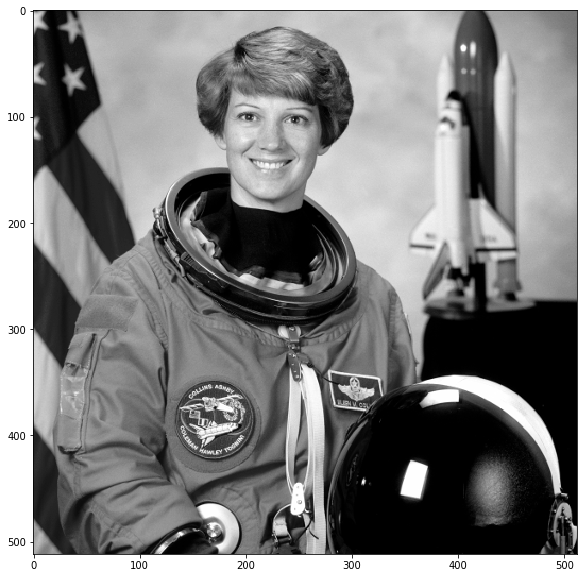

In [5]:
img = data.astronaut()
img = rgb2gray(img)*255 # convert to gray and change scale from (0,1) to (0,255).

n = img.shape[0]

plt.figure(1, figsize=(10, 10))
plt.imshow(img, cmap='gray', vmin=0, vmax=255)
plt.show()

## Compute the differences operators here. Use your code from Assignment 1.

In [6]:
# You will need these three methods to construct sparse differences operators.
# If you do not use sparse operators you might have scalability problems.
from scipy.sparse import diags
from scipy.sparse import kron
from scipy.sparse import identity
m = img.shape[0] # ROWS
n = img.shape[1] # COLS


I = diags([1], [0],shape=(n,n),dtype='int8')
J = diags([-1,1],[0,1],shape=(m,m),dtype='int8')
Dh = kron(J, I)
Dv = kron(I, J)

# Use your code from Assignment 1. 
# Make sure that you compute the right D_h and D_v matrices.

## Add noise to the image

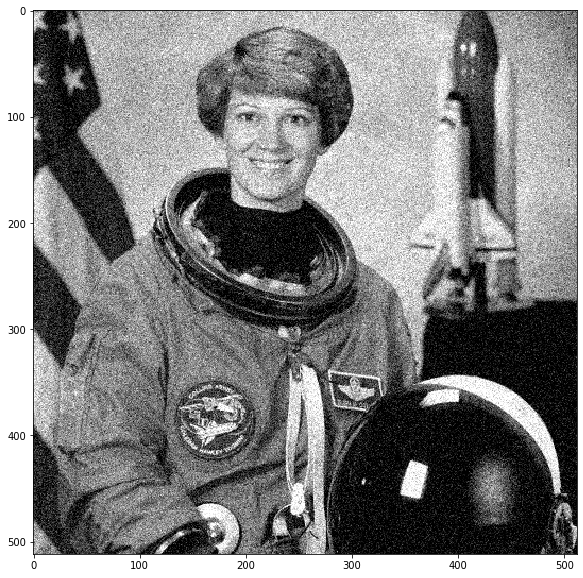

In [7]:
mean_ = 0
standard_deviation = 30
dimensions = (n,n)

noise = np.random.normal(mean_,standard_deviation,dimensions)

noisy_image = img + noise

plt.figure(1, figsize=(10, 10))
plt.imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
plt.show()

## Question 1: implement gradient descent using the Lipschitz constant as the step-size for the denoising problem. Use eigsh method from scipy.sparse.linalg to compute the Lipschitz constant. Marks: 10

In [8]:
from scipy.sparse import csr_matrix # sparse matrix
from scipy.sparse.linalg import norm # compute the norm of a sparse matrix
from scipy import real
from scipy.sparse.linalg import spsolve 
from scipy.sparse.linalg import eigsh
from numpy.linalg import norm
import math
import time

# find lipschitz constant 
# !!! we comment this because computing L is time-consuming.
# I_mn_mn = identity(m*n)
# A = lambda_*(Dh.transpose().dot(Dh) + Dv.transpose().dot(Dv)) + I_mn_mn
# eigv = eigsh(A.transpose().dot(A), 1, which='LM', return_eigenvectors=False)
# L = math.sqrt(eigv)
# eigv =  1088.98015996, L = 32.999699391964164
L = 32.999699391964164
def gradient_descent(x0, epsilon, lambda_, max_iterations):
    
# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.
    counter = 0
    x = x0
    xs = list()     # xs is list of the x calcualted in each iteration
    xs.append(x)
    D = Dh + 1J * Dv
    # D_conjugate_transpose = D.conjugate().transpose()
    # lecture 5 Slide 31
    Dct = D.conjugate().transpose()
    gradient_f_x = lambda_ * real(Dct.dot(D.dot(x))) + x - x0  # x0 is z_noisy                      # need to convert to ndarray. Otherwise wont work...
    start = time.time()
    while counter < max_iterations and norm(gradient_f_x,2) > epsilon:
        x = x - (1/L)*gradient_f_x              # lecture 5 slide 16, cumputer x_k+1
        xs.append(x.flatten('F'))
        gradient_f_x = lambda_ * real(Dct.dot(D.dot(x))) + x - x0   # update gradient
        counter += 1                                                # update countertoarray
    end = time.time()
    print('Iterations: ', counter)
    print('running time: %s seconds'% str(end-start)[0:4])
    return xs

## Call Gradient Descent

In [9]:
# Initialize parameters of gradient descent.
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
x0 = noisy_image.flatten('F')
list_of_x = gradient_descent(x0, epsilon, lambda_, max_iterations)


Iterations:  357
running time: 4.10 seconds


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

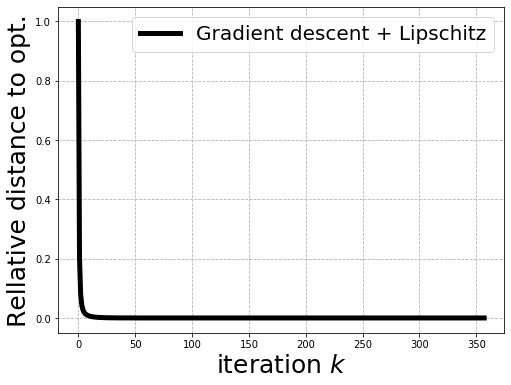

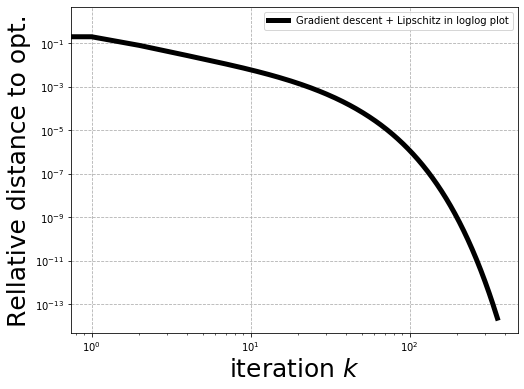

In [10]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

# Here is an example code
# helper function

def denoising(x):
    return lambda_/2 * math.pow(norm(D.dot(x), 2),2) + 1/2 * math.pow(norm(x-x0),2)

store_data_for_plotting = list()
D = Dh + 1J * Dv
A = lambda_*real(Dh.transpose().dot(Dh) + Dv.transpose().dot(Dv)) + identity(m*n)
x_minimizer = spsolve(A,x0)
f_minimizer = denoising(x_minimizer)
f_x0 = denoising(x0)
denominator = f_x0-f_minimizer
for x in list_of_x:
    numerator = denoising(x.flatten('F')) - f_minimizer
    store_data_for_plotting.append(numerator / denominator)



fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()


fig = plt.figure(figsize=(8, 6))
plt.loglog(store_data_for_plotting,label=("Gradient descent + Lipschitz in loglog plot"), linewidth=5.0, color ="black")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()


In [11]:
## Question 2: is there a "gap" between the practical convergence rate and the theoretical convergence rate? Note that the denoising objective function is strongly convex. Marks: 5

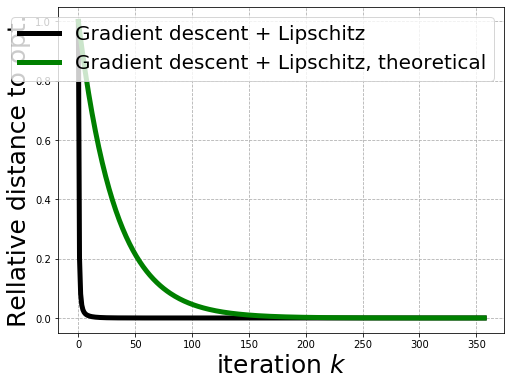

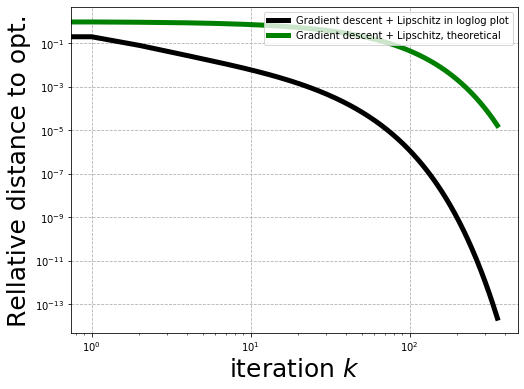

In [12]:
# the theoretical convergence rate is O(log(1/ε))
# There is a gap between theoretical and practical convergence rate. According to the plot, the practical convergence
# rate is larger than the theoretical one. The convexity might be a reason as the denoising function is strongly convexed.
# http://www.mit.edu/~rakhlin/6.883/lectures/recitation_1.pdf 
# According to the lemma 4(b) in page 3, provides intuition as to why Gradient Descent methods converge faster for strongly-convex functions.

# generate theoretical data for plotting
store_data_for_plotting_q2 = [(1- 1/L)**x for x in range(len(store_data_for_plotting))]

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting, label=("Gradient descent + Lipschitz"), linewidth=5.0, color ="black")

plt.plot(store_data_for_plotting_q2, label=("Gradient descent + Lipschitz, theoretical"), linewidth=5.0, color ="green")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()


fig = plt.figure(figsize=(8, 6))

plt.loglog(store_data_for_plotting,label=("Gradient descent + Lipschitz in loglog plot"), linewidth=5.0, color ="black")
plt.loglog(store_data_for_plotting_q2,label=("Gradient descent + Lipschitz, theoretical"), linewidth=5.0, color ="green")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()



## Question 3: implement gradient descent with line-search for the denoising problem. Marks: 15

In [13]:
D = Dh + 1j * Dv
Dct = D.conjugate().transpose()
# Write a line-search function here. 
# I am giving you a hint about what the input could be, but feel free to change the template. 
# def line_search(x,D,Dx,vec_image,grad_reg,grad_fit,lambda_):

# D: represents the complex forward differences matrix from the Lecture notes.
# Dx: represents the matrix-vector product of D times x.
# vec_image: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.

# Write your code here.
def line_search(x, gradient_f_x):
    alpha_=1
    diff = x - alpha_ * gradient_f_x
    LHS = denoising(diff)
    RHS = denoising(x)
    while LHS >= RHS:
        alpha_ = alpha_ / 2
        diff = x - alpha_ * gradient_f_x
        LHS = denoising(diff)
#         RHS does not change
#         RHS = denoising(x)    #!!! this step significantly changes the time consumed!!!!!!!!.
    return alpha_
        
# Write gradient descent + line-search here.
# I am giving you a hint about what the input could be, but feel free to change the template. 
def gradient_descent_ls(x0, epsilon, lambda_, max_iterations):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.

# Write your code here.
    counter = 0
    x = x0
    xs = [x]
    gradient_f_x = lambda_ * real(Dct.dot(D.dot(x))) + x - x0
    start = time.time()
    while counter < max_iterations and norm(gradient_f_x,2) > epsilon:
        alpha_ = line_search(x, gradient_f_x)
        x = x - alpha_ * gradient_f_x
        gradient_f_x = lambda_ * real(Dct.dot(D.dot(x))) + x - x0
        xs.append(x)
        counter += 1
    end = time.time()
    print('Iterations: ', counter)
    print('running time: %s seconds'% str(end-start)[0:4])
    return xs

## Call Gradient Descent with line-search

In [14]:
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000

# Set x0 equal to the vectorized noisy image.
# Write your code here.
x0 = noisy_image.flatten('F')
list_of_x_q3 = gradient_descent_ls(x0, epsilon, lambda_, max_iterations)

Iterations:  91
running time: 3.84 seconds


### Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

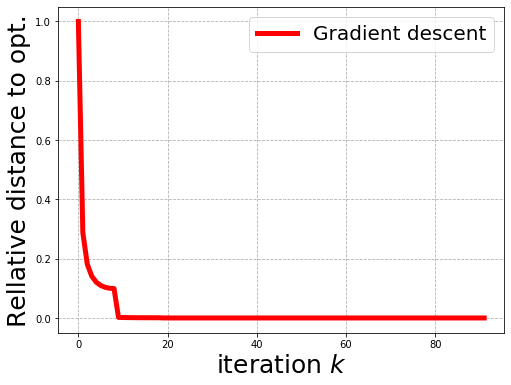

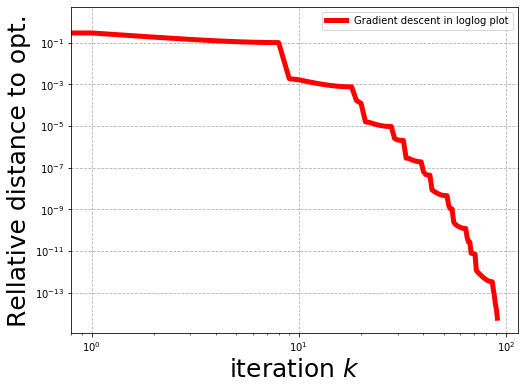

In [15]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

# Here is an example code
store_data_for_plotting_q3 = []
denominator = f_x0-f_minimizer
for x in list_of_x_q3:
    numerator = denoising(x.flatten('F')) - f_minimizer
    store_data_for_plotting_q3.append(numerator / denominator)
    
# Here is an example code 

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting_q3, label=("Gradient descent"), linewidth=5.0, color ="red")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')

fig = plt.figure(figsize=(8, 6))
plt.loglog(store_data_for_plotting_q3,label=("Gradient descent in loglog plot"), linewidth=5.0, color ="red")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 4: What is the advantage of using line-search to compute the step-size at each iteration instead of using constant step-sizes equal to 1/L? Where L is the Lipschitz constant. Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of running time when you add computation of the Lipschitz constant in the running time? Is gradient descent with line-search faster than gradient descent with constant step-sizes in terms of number of required iterations? Marks: 10

In [16]:
# A: However, in practice knowing L is not necessary. (Lecture04.pdf Slide 19)
# Calculating L is time consuming as it requires solving the eigenvalues of a  n^2 by n^2 matrix.
# Using line-search to compute the step-size saves the time as the worst case costs log(L)/log(2). (Lecture 04 slide 26)

# B: Yes. Gradient descent with line-search faster than gradient descent with constant step-sizes.

# C: Yes. Gradient descent with line-search faster than gradient descent with constant step-sizes when I add computation of the Lipschitz constant in the running time

# D: Gradient descent satisfies the termination condition after 357 iterations but gradient descent with line-search  terminates after 92 iterations.


## Questions 5: implement gradient descent with Armijo line-search for the denoising problem. Marks: 10

In [17]:
# Create a line-search function
def line_search_Armijo(x, grad, gamma_):

# D: represents the complex forward differences matrix from the Lecture notes.
# Dx: represents the matrix-vector product of D times x.
# vec_image: is the vectorized noisy image
# grad_reg: is the gradient of the regularization term ||Dx||_2^2
# grad_fit: is the gradient of the least-squares term ||x-vec_image||_2^2
# lambda_: is the regularization parameter of the denoising problem.
# gamma: parameter of Armijo line-search as was defined in the lectures.
# second_grad_22: second_order_gradient_of fx 

# Write your code here.

    alpha_ = 1
    diff = x - alpha_ * grad
    # store the value for reuse
#     deno_x = denoising(x)
    LHS = denoising(diff)
    RHS = denoising(x) - alpha_ * gamma_ * norm(grad) ** 2
    while LHS > RHS:
        alpha_ /= 2
        diff = x - alpha_ * grad
        LHS = denoising(diff)
        RHS = denoising(x) - alpha_ * gamma_ * norm(grad) ** 2
    return alpha_


def gradient_descent_Armijo(x0, epsilon, lambda_, max_iterations, gamma_):

# x0: is the initial guess for the x variables
# epsilon: is the termination tolerance parameter
# lambda_: is the regularization parameter of the denoising problem.
# max_iterations: is the maximum number of iterations that you allow the algorithm to run.
# gamma: parameter of Armijo line-search as was defined in the lectures.

# Write your code here.
    
#   second_grad_22 = lambda_*(Dh.transpose().dot(Dh) + Dv.transpose().dot(Dv)) + identity(m*n)
    counter = 0
    D = Dh + 1j * Dv
    Dct = D.conjugate().transpose()
    # list
    x = x0
    xs = [x]
    gradient_f_x = lambda_ * real(Dct.dot(D.dot(x))) + x - x0
#   grad_22 = math.pow(norm(gradient_f_x,2),2)
    start = time.time()
    while norm(gradient_f_x, 2) > epsilon and counter < max_iterations:
#       x = line_search_als(x, gradient_f_x, gamma_)
        alpha_ = line_search_Armijo(x, gradient_f_x, gamma_)
        x = x - alpha_ * gradient_f_x
        gradient_f_x = lambda_ * real(Dct.dot(D.dot(x))) + x - x0
        xs.append(x)
        counter += 1
    end = time.time()
    print('Iterations: ', counter)
    print('running time: %s seconds'% str(end-start)[0:4])
    return xs


## Call Gradient Descent with Armijo line search

In [24]:
# # Initialize parameters of gradient descent
# lambda_ = 4
# epsilon = 1.0e-2
# max_iterations = 2000
# gamma_ = 0.4

# # Set x0 equal to the vectorized noisy image.
# # Write your code here.

# x0 = noisy_image.flatten('F')
# list_of_x_q5 = gradient_descent_ar(x0, epsilon, lambda_, max_iterations, gamma_)
# Initialize parameters of gradient descent
lambda_ = 4
epsilon = 1.0e-2
max_iterations = 2000
gamma_ = 0.3   # terminates in 82 iteration
gamma_ = 0.4   # terminates in 98 iteration
gamma_ = 0.5   # terminates in 93 iteration
# Set x0 equal to the vectorized noisy image.

# Write your code here.
list_of_x_q5 = gradient_descent_Armijo(x0, epsilon, lambda_, max_iterations, gamma_)

Iterations:  93
running time: 6.58 seconds


## Plot $$(f(x_k) - f(x^*)) / (f(x_0) - f(x^*))$$ vs the iteration counter k, where $$x^*$$ is the minimizer of the denoising problem, which you can compute by using spsolve, similarly to Assignment 1.

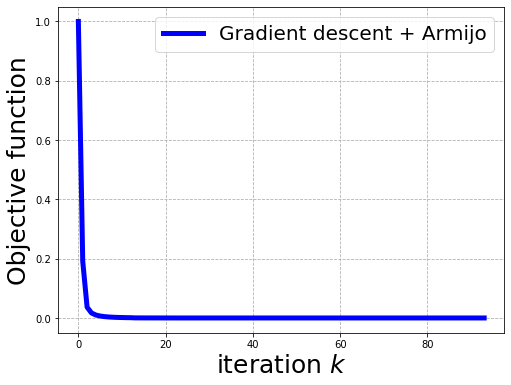

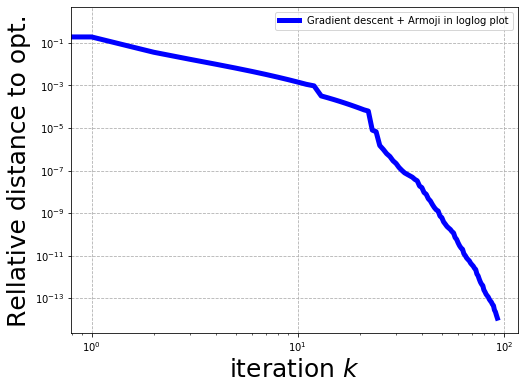

In [25]:
# Plot the rellative objective function vs number of iterations. 

# Write your code here.

# Here is an example code 
store_data_for_plotting_q5 = []
denominator = f_x0-f_minimizer
for x in list_of_x_q5:
    numerator = denoising(x.flatten('F')) - f_minimizer
    store_data_for_plotting_q5.append(numerator / denominator)

fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting_q5, label=("Gradient descent + Armijo"), linewidth=5.0, color ="blue")

plt.legend(prop={'size': 20},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Objective function", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()



fig = plt.figure(figsize=(8, 6))
plt.loglog(store_data_for_plotting_q5,label=("Gradient descent + Armoji in loglog plot"), linewidth=5.0, color ="blue")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Question 6: Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of running time? Is gradient descent with Armijo line-search faster than gradient descent with simple line-search in terms of number of required iterations? Explain any performance differences between the two approaches. Marks: 10

In [21]:
# A: No. gradient descent with Armijo line-search slower than gradient descent with simple line-search in terms of running time
# It requires less iterations but takes less than a second longer time. （if we set gamma_ to be 0.4
# The reason could be that armijo line-search takes more steps of computation than line-search.
# Armoji line search: we need to update RHS in each iteration RHS = deno_x - alpha_ * gamma_ * norm(grad) ** 2
# Simple line-search : no need to update RHS.

# B: In our case gradient descent with Armijo line-search is slower.
# but if we uncomment the code and compute RHS in every itertions. Armijo(4.00s) is 1/3 faster than simple line-search (6.14s and 3.81s)

# C: Theoretically the armijo line search should be faster because:
# In armijo line search
# f(x_k − γαf(xk)) ≤ f(x_k) − αγ||▽f(x_k)k||_2^2 ==> 
# f(x_k+1) - f(x_k) <= − αγ||▽f(x_k)k||_2^2
# Simple line search guarantees that 
# f(x_k+1) - f(x_k) <= 0

# In Armijo line-search, the lower bound is a negative number. In simple line search, the lower bound is 0.
# That is, in Armijo line-search, f(x) get more closer to f*, the minimizer. It converges faster.

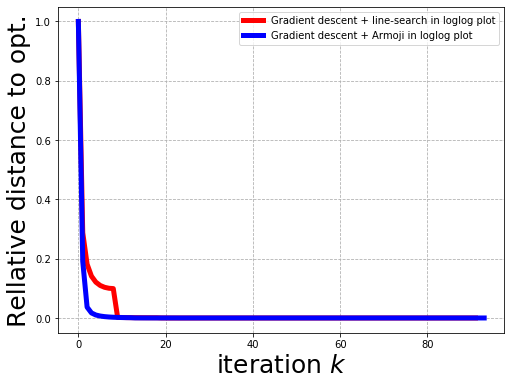

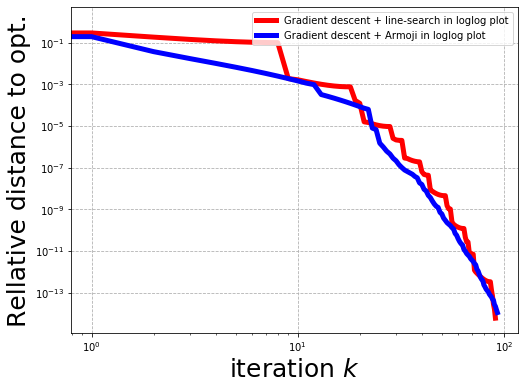

In [28]:
# plot the data for gradient descent with line-search and armijo line-search together.....
fig = plt.figure(figsize=(8, 6))
plt.plot(store_data_for_plotting_q3,label=("Gradient descent + line-search in loglog plot"), linewidth=5.0, color ="red")
plt.plot(store_data_for_plotting_q5,label=("Gradient descent + Armoji in loglog plot"), linewidth=5.0, color ="blue")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

fig = plt.figure(figsize=(8, 6))
plt.loglog(store_data_for_plotting_q3,label=("Gradient descent + line-search in loglog plot"), linewidth=5.0, color ="red")
plt.loglog(store_data_for_plotting_q5,label=("Gradient descent + Armoji in loglog plot"), linewidth=5.0, color ="blue")
plt.legend(prop={'size': 10},loc="upper right")
plt.xlabel("iteration $k$", fontsize=25)
plt.ylabel("Rellative distance to opt.", fontsize=25)
plt.grid(linestyle='dashed')
plt.show()

## Mathematical Questions

## Question 7: prove that the denoising objective function is strongly convex. What is its strong convexity parameter? Marks: 5

## Question 8: Prove that Armijo line-search will terminate after a finite number of steps. Hint: show that there exists a step-size $$\alpha^*>0$$ such that for any step-size smaller than $$\alpha^*$$ the termination condition of Armijo line-search is satisfied. How many iterations will be required in worst-case for Armijo line-search to terminate? Marks 15

## Question 9: what is the running time for gradient descent with Armijo line-search for the denoising problem to achieve $$f(x_k) - f^* \le \epsilon$$ ?. The running time is computed by multiplying the worst-case iteration complexity times the FLOPS at each iteration. The FLOPS at each iteration is the number of additions, subtractions, multiplications and divisions that are performed during the current iteration. 10

## Question 10: prove the convergence rate and iteration complexity for gradient descent with constant step-sizes (equal to 1/L) for strongly convex functions. Marks: 10